<a href="https://colab.research.google.com/github/genigarus/EVA4/blob/master/EVA4_S5_File3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN on MNIST Data 
---

Link to colab : https://colab.research.google.com/drive/1THoV7fUXcQ1tdIHk5OMSCe2YOe-FhiqB


**Target**:

> Reduce number of parameters to about 10k and add dropout to handle overfitting.

**Results**:

> Parameters: 10,008

> Best Train Accuracy: 99.27%

> Best Test Accuracy: 99.38%

**Analysis**:

> I was able to bring down the number of parameters to about 10k by reducing the number of kernels and the gain in parameter space was filled by another 1x1 convolution layer(FC layer). Thus, balancing out the reduction in parameters without affecting test accuracy. 

> I added a small dropout of 0.05 to handle over-fitting because adding large values tended to decrease the test accuracy though decreasing difference between train and test accuracy. This value was kind of trade-off between decrease in difference between train and test accuracy, and keeping test accuracy around 99.3%.

> Reduction in number of kernels also reduces over-fitting.


## Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations
--- 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## The model
---

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x16, RF = 18x18
                
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x16, RF = 38x38
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x10, RF = 38x38 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.037898387759923935 Batch_id=468 Accuracy=85.71: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.029656216502189636 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:11<00:00, 39.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


Loss=0.12738604843616486 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.030984699726104736 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.022846290841698647 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.06625532358884811 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.010391071438789368 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.018596509471535683 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.053383562713861465 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.0066705443896353245 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.025800436735153198 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 38.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.010144601576030254 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.00692419707775116 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.09015268087387085 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.018211817368865013 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.07it/s]



Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

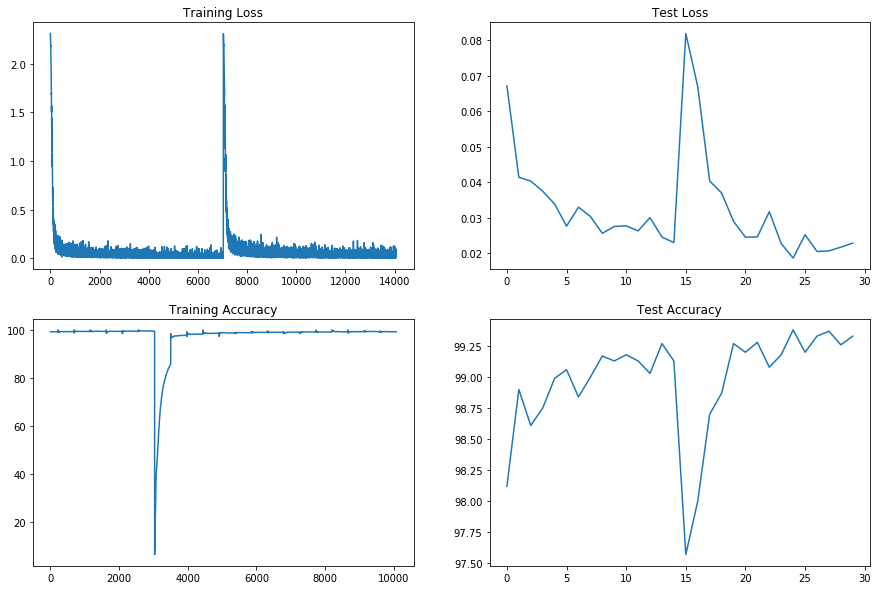

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")